# Import libraries

In [1]:
%pylab nbagg
%matplotlib inline
from tvb.simulator.lab import *
import pickle as cPickle
import numpy as np
import pandas as pd
import os
import bayesopt
import nilearn

LOG = get_logger('demo')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Set values of the simulator

In [2]:
#The best values of correlation extracted from the grid
spd = 3

#Other default values
dt = 0.01

#Global values
gca = 0.00013436
gcb = 0.199603

#Simulation length
sim_len = 4000

#Intrinsic values of SJ3D
k11 = 0.5 #hi=1.0 #lo=0.0
k12 = 0.5 #hi=1.0 #lo=0.0
k21 = 0.5 #hi=1.0 #lo=0.0
r = 0.006 #hi=0.1 #lo=0.0
a = 1.0 #hi=1.0 #lo=0.0
b = 3.0 #hi=3.0 #lo=0.0
c = 1.0 #hi=1.0 #lo=0.0
d = 5.0 #hi=7.5 #lo=2.5
s = 4.0 #hi=6.0 #lo=2.0
sigma = 0.35 #hi=1.0 #lo=0.0
mu = 3.3 #hi=1.1 #lo=3.3
xo = -1.6 #hi=-0.8 #lo=-2.4

# Import connectivity and empirical FC

In [3]:
#Connectivity (nodes of stroke reduced to 0)
conn = connectivity.Connectivity.from_file('new_connectivity.zip')
#Load empirical functional connectivity
empirical_fc = pd.read_csv('empirical_fc.csv', header=None)

# Simple simulation

In [47]:
#Simulation length
sim_len = 2000

#Integration time
dt = 0.1

mod = models.ReducedSetHindmarshRose(
    K11=np.array(k11),
    K12=np.array(k12),
    K21=np.array(k21),
    r=np.array(r),
    a=np.array(a), 
    b=np.array(b), 
    c=np.array(c),
    d=np.array(d),
    s=np.array(s),
    sigma=np.array(sigma),
    mu=np.array(mu),
    xo=np.array(xo))
    
    
#Coupling (linear a and b defined above)
cpl = coupling.Linear(a=np.array(0), b=np.array(0))
solver = integrators.HeunStochastic(dt=dt)

mons =(monitors.Bold(period=900), monitors.ProgressLogger(period=100))
sim = simulator.Simulator(model=mod,connectivity=conn,coupling=cpl, conduction_speed = 80,
                        integrator=solver, monitors=mons, simulation_length=sim_len)
sim.configure()
(bold_time, bold_data), _ = sim.run()
bold_data = bold_data[:, 0, :, 0]

sim_fc = np.corrcoef(np.transpose(bold_data))
sim_fc = np.delete(sim_fc,(20,22),0)
sim_fc = np.delete(sim_fc,(20,22),1)

corr_matrix = np.corrcoef(sim_fc, empirical_fc)

e = np.mean(np.absolute(corr_matrix))

value_to_optimize = 1 - e

print(value_to_optimize)

   INFO  step 1 time 0.0001 s
   INFO  step 1001 time 0.1001 s
   INFO  step 2001 time 0.2001 s
   INFO  step 3001 time 0.3001 s
   INFO  step 4001 time 0.4001 s
   INFO  step 5001 time 0.5001 s
   INFO  step 6001 time 0.6001 s
   INFO  step 7001 time 0.7001 s
   INFO  step 8001 time 0.8001 s
   INFO  step 9001 time 0.9001 s
   INFO  step 10001 time 1.0001 s
   INFO  step 11001 time 1.1001 s
   INFO  step 12001 time 1.2001 s
   INFO  step 13001 time 1.3001 s
   INFO  step 14001 time 1.4001 s
   INFO  step 15001 time 1.5001 s
   INFO  step 16001 time 1.6001 s
   INFO  step 17001 time 1.7001 s
   INFO  step 18001 time 1.8001 s
   INFO  step 19001 time 1.9001 s
nan


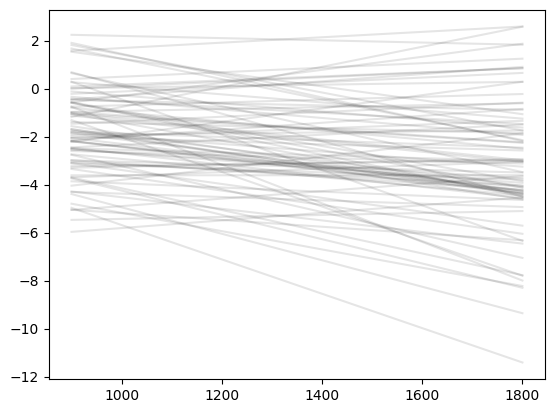

In [39]:
figure()
plot(bold_time, bold_data, 'k', alpha=0.1)

# Save previous state

In [7]:
sim_state_fname = 'sim_state.pickle'

with open(sim_state_fname, 'wb') as file_descr:
    cPickle.dump({
        'history': sim.history.buffer,
        'current_step': sim.current_step,
        'current_state': sim.current_state,
        'bold': sim.monitors[1]._stock,
        'rng': sim.integrator.noise.random_stream.get_state()
    }, file_descr)

In [8]:
!ls -lh sim_state.pickle
del sim

/bin/bash: /home/aescalera/BitBrain/TVB_Distribution/tvb_data/lib/libtinfo.so.6: no version information available (required by /bin/bash)
-rw-rw-r-- 1 aescalera aescalera 16M ene 12 16:12 sim_state.pickle


# Global variables optmization

In [4]:
#Simulation length
sim_len = 25000

#Integration time
dt = 0.01

def func(x):
    x[1] = x[1]*100
    x[2] = x[2]*20000
    print(x)
    #Stefanescu-Jirsa 3D
    mod = models.ReducedSetHindmarshRose(
    K11=np.array(k11),
    K12=np.array(k12),
    K21=np.array(k21),
    r=np.array(r),
    a=np.array(a), 
    b=np.array(b), 
    c=np.array(c),
    d=np.array(d),
    s=np.array(s),
    sigma=np.array(sigma),
    mu=np.array(mu),
    xo=np.array(xo))
    
    
    #Coupling
    cpl = coupling.Linear(a=np.array(x[0]), b=np.array(x[1]))
    solver = integrators.HeunStochastic(dt=dt)

    mons =(monitors.Bold(period=900), monitors.ProgressLogger(period=1000))
    sim = simulator.Simulator(model=mod,connectivity=conn,coupling=cpl, conduction_speed = x[2],
                            integrator=solver, monitors=mons, simulation_length=sim_len)
    sim.configure()
    (bold_time, bold_data), _ = sim.run()
    bold_data = bold_data[:, 0, :, 0]
    
    sim_fc = np.corrcoef(np.transpose(bold_data))
    sim_fc = np.delete(sim_fc,(20,22),0)
    sim_fc = np.delete(sim_fc,(20,22),1)

    corr_matrix = np.corrcoef(sim_fc, empirical_fc)
    
    value_to_optimize = 1 - np.mean(np.absolute(corr_matrix))
    
    print(value_to_optimize)
    
    if np.isnan(value_to_optimize):
        print('Nan values generated, setting it as a bad run')
        value_to_optimize = 1000
    
    return value_to_optimize

# Initialize the parameters by default
params = {} #bayesopt.initialize_params()

# We decided to change some of them
params['n_iterations'] = 20
params['n_init_samples'] = 5
params['n_iter_relearn'] = 1
params['l_type'] = "mcmc"
params['verbose_level'] = 5

dim = 3
lb = np.ones((dim,))*0
ub = np.ones((dim,))*0.0005

mvalue, x_out, error = bayesopt.optimize(func, dim, lb, ub, params)

print("Result", mvalue, x_out)

print("Global optimal", 0, np.arange(1,1+dim))

print("Y Gap", mvalue)
print("X Gap", math.sqrt(mvalue*dim))

#1.96195864e-04 1.89990532e-05 0.94

[3.83915291e-04 4.49978602e-02 7.59373518e+00]
   INFO  step 1 time 0.0000 s


/home/aescalera/BitBrain/TVB_Distribution/tvb_data/lib/python3.10/site-packages/tvb/simulator/models/stefanescu_jirsa.py:526: RuntimeWarning: overflow encountered in power
  derivative[0] = (eta - self.a_i * xi ** 3 + self.b_i * xi ** 2 - tau +
/home/aescalera/BitBrain/TVB_Distribution/tvb_data/lib/python3.10/site-packages/tvb/simulator/models/stefanescu_jirsa.py:526: RuntimeWarning: overflow encountered in square
  derivative[0] = (eta - self.a_i * xi ** 3 + self.b_i * xi ** 2 - tau +
/home/aescalera/BitBrain/TVB_Distribution/tvb_data/lib/python3.10/site-packages/tvb/simulator/models/stefanescu_jirsa.py:526: RuntimeWarning: invalid value encountered in add
  derivative[0] = (eta - self.a_i * xi ** 3 + self.b_i * xi ** 2 - tau +
/home/aescalera/BitBrain/TVB_Distribution/tvb_data/lib/python3.10/site-packages/tvb/simulator/models/stefanescu_jirsa.py:531: RuntimeWarning: overflow encountered in square
  derivative[1] = self.c_i - self.d_i * xi ** 2 - eta
/home/aescalera/BitBrain/TVB_Distr

   INFO  step 100001 time 1.0000 s
   INFO  step 200001 time 2.0000 s
   INFO  step 300001 time 3.0000 s
   INFO  step 400001 time 4.0000 s
   INFO  step 500001 time 5.0000 s
   INFO  step 600001 time 6.0000 s
   INFO  step 700001 time 7.0000 s
   INFO  step 800001 time 8.0000 s
   INFO  step 900001 time 9.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1100001 time 11.0000 s
   INFO  step 1200001 time 12.0000 s
   INFO  step 1300001 time 13.0000 s
   INFO  step 1400001 time 14.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 1600001 time 16.0000 s
   INFO  step 1700001 time 17.0000 s
   INFO  step 1800001 time 18.0000 s
   INFO  step 1900001 time 19.0000 s
   INFO  step 2000001 time 20.0000 s
   INFO  step 2100001 time 21.0000 s
   INFO  step 2200001 time 22.0000 s
   INFO  step 2300001 time 23.0000 s
   INFO  step 2400001 time 24.0000 s
nan
Nan values generated, setting it as a bad run
[4.18348653e-04 2.06165557e-02 9.06346706e+00]
   INFO  step 1 time 0.0000 s


/home/aescalera/BitBrain/TVB_Distribution/tvb_data/lib/python3.10/site-packages/tvb/simulator/integrators.py:361: RuntimeWarning: invalid value encountered in add
  dX = (m_dx_tn + dfun(inter, coupling, local_coupling)) * self.dt / 2.0
/home/aescalera/BitBrain/TVB_Distribution/tvb_data/lib/python3.10/site-packages/tvb/simulator/coupling.py:170: RuntimeWarning: overflow encountered in multiply
  sum[:, nzr] = numpy.add.reduceat(weights_col * pre, lri, axis=1)


   INFO  step 100001 time 1.0000 s
   INFO  step 200001 time 2.0000 s
   INFO  step 300001 time 3.0000 s
   INFO  step 400001 time 4.0000 s
   INFO  step 500001 time 5.0000 s
   INFO  step 600001 time 6.0000 s
   INFO  step 700001 time 7.0000 s
   INFO  step 800001 time 8.0000 s
   INFO  step 900001 time 9.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1100001 time 11.0000 s
   INFO  step 1200001 time 12.0000 s
   INFO  step 1300001 time 13.0000 s
   INFO  step 1400001 time 14.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 1600001 time 16.0000 s
   INFO  step 1700001 time 17.0000 s
   INFO  step 1800001 time 18.0000 s
   INFO  step 1900001 time 19.0000 s
   INFO  step 2000001 time 20.0000 s
   INFO  step 2100001 time 21.0000 s
   INFO  step 2200001 time 22.0000 s
   INFO  step 2300001 time 23.0000 s
   INFO  step 2400001 time 24.0000 s
nan
Nan values generated, setting it as a bad run
[1.66129236e-04 9.16225476e-03 3.15093582e-01]
   INFO  step 1 time 0.0000 s
   

   INFO  step 1400001 time 14.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 1600001 time 16.0000 s
   INFO  step 1700001 time 17.0000 s
   INFO  step 1800001 time 18.0000 s
   INFO  step 1900001 time 19.0000 s
   INFO  step 2000001 time 20.0000 s
   INFO  step 2100001 time 21.0000 s
   INFO  step 2200001 time 22.0000 s
   INFO  step 2300001 time 23.0000 s
   INFO  step 2400001 time 24.0000 s
0.6660090402168286
[0.00021269 0.00689312 0.09841919]
   INFO  step 1 time 0.0000 s
   INFO  step 100001 time 1.0000 s
   INFO  step 200001 time 2.0000 s
   INFO  step 300001 time 3.0000 s
   INFO  step 400001 time 4.0000 s
   INFO  step 500001 time 5.0000 s
   INFO  step 600001 time 6.0000 s
   INFO  step 700001 time 7.0000 s
   INFO  step 800001 time 8.0000 s
   INFO  step 900001 time 9.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1100001 time 11.0000 s
   INFO  step 1200001 time 12.0000 s
   INFO  step 1300001 time 13.0000 s
   INFO  step 1400001 time 14.0000 s
   INFO  

   INFO  step 100001 time 1.0000 s
   INFO  step 200001 time 2.0000 s
   INFO  step 300001 time 3.0000 s
   INFO  step 400001 time 4.0000 s
   INFO  step 500001 time 5.0000 s
   INFO  step 600001 time 6.0000 s
   INFO  step 700001 time 7.0000 s
   INFO  step 800001 time 8.0000 s
   INFO  step 900001 time 9.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1100001 time 11.0000 s
   INFO  step 1200001 time 12.0000 s
   INFO  step 1300001 time 13.0000 s
   INFO  step 1400001 time 14.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 1600001 time 16.0000 s
   INFO  step 1700001 time 17.0000 s
   INFO  step 1800001 time 18.0000 s
   INFO  step 1900001 time 19.0000 s
   INFO  step 2000001 time 20.0000 s
   INFO  step 2100001 time 21.0000 s
   INFO  step 2200001 time 22.0000 s
   INFO  step 2300001 time 23.0000 s
   INFO  step 2400001 time 24.0000 s
0.5785029127860715
[0.000257   0.04999907 0.00098189]
WARNING  There may be insufficient memory for this simulation.
   INFO  step

/home/aescalera/BitBrain/TVB_Distribution/tvb_data/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


   INFO  step 100001 time 1.0000 s
   INFO  step 200001 time 2.0000 s
   INFO  step 300001 time 3.0000 s
   INFO  step 400001 time 4.0000 s
   INFO  step 500001 time 5.0000 s
   INFO  step 600001 time 6.0000 s
   INFO  step 700001 time 7.0000 s
   INFO  step 800001 time 8.0000 s
   INFO  step 900001 time 9.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1100001 time 11.0000 s
   INFO  step 1200001 time 12.0000 s
   INFO  step 1300001 time 13.0000 s
   INFO  step 1400001 time 14.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 1600001 time 16.0000 s
   INFO  step 1700001 time 17.0000 s
   INFO  step 1800001 time 18.0000 s
   INFO  step 1900001 time 19.0000 s
   INFO  step 2000001 time 20.0000 s
   INFO  step 2100001 time 21.0000 s
   INFO  step 2200001 time 22.0000 s
   INFO  step 2300001 time 23.0000 s
   INFO  step 2400001 time 24.0000 s
0.7219867651321921
Result 0.5438684796789701 [1.96195864e-04 1.89990532e-07 4.71659112e-04]
Global optimal 0 [1 2 3]
Y Gap 0.54386

# Single zone parametrization

In [7]:
#Simulation length
sim_len = 25000

#Integration time
dt = 0.01

def func(x):
    print(x)
    #Stefanescu-Jirsa 3D
    mod = models.ReducedSetHindmarshRose(
    K11=np.array(x[0]),
    K12=np.array(x[1]),
    K21=np.array(x[2]),
    r=np.array(x[3]/10),
    a=np.array(x[4]), 
    b=np.array(x[5]*3), 
    c=np.array(x[6]),
    d=np.array(x[7]*5 + 2.5),
    s=np.array(x[8]*4 + 2),
    sigma=np.array(x[9]),
    mu=np.array(x[10]*3 + 1.1),
    xo=np.array(x[11]*-2- 0.8))
    
    
    #Coupling
    cpl = coupling.Linear(a=np.array(1.96195864e-04), b=np.array(1.89990532e-05))
    solver = integrators.HeunStochastic(dt=dt)

    mons =(monitors.Bold(period=900), monitors.ProgressLogger(period=5000))
    sim = simulator.Simulator(model=mod,connectivity=conn,coupling=cpl, conduction_speed = 0.94,
                            integrator=solver, monitors=mons, simulation_length=sim_len)
    sim.configure()
    (bold_time, bold_data), _ = sim.run()
    bold_data = bold_data[:, 0, :, 0]
    
    sim_fc = np.corrcoef(np.transpose(bold_data))
    sim_fc = np.delete(sim_fc,(20,22),0)
    sim_fc = np.delete(sim_fc,(20,22),1)

    corr_matrix = np.corrcoef(sim_fc, empirical_fc)
    
    value_to_optimize = 1 - np.mean(np.absolute(corr_matrix))
    
    print(value_to_optimize)
    
    if np.isnan(value_to_optimize):
        print('Nan values generated, setting it as a bad run')
        value_to_optimize = 1000
    
    return value_to_optimize

# Initialize the parameters by default
params = {} #bayesopt.initialize_params()

# We decided to change some of them
params['n_iterations'] = 30
params['n_init_samples'] = 10
params['n_iter_relearn'] = 2
params['l_type'] = "mcmc"

dim = 12
lb = np.ones((dim,))*0
ub = np.ones((dim,))*1

mvalue, x_out, error = bayesopt.optimize(func, dim, lb, ub, params)

print("Result", mvalue, x_out)

print("Global optimal", 0, np.arange(1,1+dim))

print("Y Gap", mvalue)
print("X Gap", math.sqrt(mvalue*dim))

[0.1368076  0.03135408 0.84398874 0.21096233 0.61898035 0.3215705
 0.5923338  0.69340027 0.55665128 0.64882495 0.48041401 0.43564979]
   INFO  step 1 time 0.0000 s
   INFO  step 500001 time 5.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 2000001 time 20.0000 s
0.5246228188710571
[0.34189437 0.44525645 0.48826912 0.76889252 0.4453601  0.00160813
 0.73336416 0.89149428 0.62919859 0.17054655 0.19413955 0.71773174]
   INFO  step 1 time 0.0000 s
   INFO  step 500001 time 5.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 2000001 time 20.0000 s
nan
Nan values generated, setting it as a bad run
[0.03442825 0.22982691 0.01564807 0.1611891  0.50139844 0.42552172
 0.63136752 0.40846649 0.48367449 0.87051745 0.05957865 0.20866293]
   INFO  step 1 time 0.0000 s
   INFO  step 500001 time 5.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 2000001 time 20.0000 s

/home/aescalera/BitBrain/TVB_Distribution/tvb_data/lib/python3.10/site-packages/tvb/simulator/models/stefanescu_jirsa.py:531: RuntimeWarning: invalid value encountered in subtract
  derivative[1] = self.c_i - self.d_i * xi ** 2 - eta
/home/aescalera/BitBrain/TVB_Distribution/tvb_data/lib/python3.10/site-packages/tvb/simulator/models/stefanescu_jirsa.py:526: RuntimeWarning: invalid value encountered in subtract
  derivative[0] = (eta - self.a_i * xi ** 3 + self.b_i * xi ** 2 - tau +


   INFO  step 500001 time 5.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 2000001 time 20.0000 s
nan
Nan values generated, setting it as a bad run
[0.73558475 0.95390027 0.53885197 0.38716583 0.2774986  0.78099571
 0.03856868 0.08636377 0.25858492 0.22643743 0.36205987 0.81761272]
   INFO  step 1 time 0.0000 s
   INFO  step 500001 time 5.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 2000001 time 20.0000 s
0.559382764446931
[0.91733034 0.68137042 0.99694422 0.66653283 0.33107356 0.87935117
 0.16769701 0.12802502 0.19242249 0.53423324 0.86710729 0.60403582]
   INFO  step 1 time 0.0000 s
   INFO  step 500001 time 5.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 2000001 time 20.0000 s
0.5583798557619002
[1.66546622e-01 9.99969263e-01 6.86691936e-01 2.01980319e-04
 9.99928916e-01 2.37574442e-01 8.88258361e-01 6.66662692e-01
 6.68504314e-01 9.74862

/home/aescalera/BitBrain/TVB_Distribution/tvb_data/lib/python3.10/site-packages/tvb/simulator/models/stefanescu_jirsa.py:526: RuntimeWarning: overflow encountered in multiply
  derivative[0] = (eta - self.a_i * xi ** 3 + self.b_i * xi ** 2 - tau +
/home/aescalera/BitBrain/TVB_Distribution/tvb_data/lib/python3.10/site-packages/tvb/simulator/models/stefanescu_jirsa.py:535: RuntimeWarning: overflow encountered in multiply
  derivative[3] = (beta - self.e_i * alpha ** 3 + self.f_i * alpha ** 2 - gamma +
/home/aescalera/BitBrain/TVB_Distribution/tvb_data/lib/python3.10/site-packages/tvb/simulator/models/stefanescu_jirsa.py:531: RuntimeWarning: overflow encountered in multiply
  derivative[1] = self.c_i - self.d_i * xi ** 2 - eta
/home/aescalera/BitBrain/TVB_Distribution/tvb_data/lib/python3.10/site-packages/tvb/simulator/integrators.py:358: RuntimeWarning: invalid value encountered in add
  inter = X + self.dt * m_dx_tn + noise + self.dt * stimulus


   INFO  step 500001 time 5.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 2000001 time 20.0000 s
nan
Nan values generated, setting it as a bad run
[0.22403346 0.81739957 0.58761019 0.13516056 0.92971825 0.35025702
 0.64751571 0.71777299 0.23566432 0.65708648 0.36994661 0.66459649]
   INFO  step 1 time 0.0000 s
   INFO  step 500001 time 5.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 2000001 time 20.0000 s
0.5395627632881979
[3.77025057e-01 6.17868158e-01 7.21672225e-02 2.00341349e-01
 8.03013827e-01 7.33677318e-01 8.87665456e-02 3.93979172e-01
 6.43394050e-04 3.48982609e-01 5.67766714e-01 9.99774825e-01]
   INFO  step 1 time 0.0000 s
   INFO  step 500001 time 5.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 2000001 time 20.0000 s
0.5638924709431459
[5.23257305e-01 2.12055656e-01 6.85639763e-04 6.12157638e-01
 1.34802734e-01 7.91751853e-01 3.7

0.5529992877746979
[7.07460953e-01 6.38825660e-01 9.99944407e-01 2.04498245e-01
 2.33847457e-01 9.50395767e-01 2.24850264e-04 2.09329910e-01
 1.79767191e-01 2.38101350e-04 9.17517459e-01 8.89164580e-01]
   INFO  step 1 time 0.0000 s


/home/aescalera/BitBrain/TVB_Distribution/tvb_data/lib/python3.10/site-packages/tvb/simulator/models/stefanescu_jirsa.py:539: RuntimeWarning: overflow encountered in multiply
  derivative[4] = self.h_i - self.p_i * alpha ** 2 - beta


   INFO  step 500001 time 5.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 2000001 time 20.0000 s
nan
Nan values generated, setting it as a bad run
[0.13610627 0.03109986 0.84525899 0.2113793  0.61974223 0.32224634
 0.59166012 0.94411515 0.55579619 0.64832863 0.4797615  0.43510829]
   INFO  step 1 time 0.0000 s
   INFO  step 500001 time 5.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 2000001 time 20.0000 s
nan
Nan values generated, setting it as a bad run
[2.65554792e-04 9.99996822e-01 8.09891902e-01 2.11800871e-01
 6.12306924e-01 3.25127709e-01 3.59220062e-01 2.25280963e-04
 9.80089594e-01 8.71212109e-01 9.99955628e-01 3.41901567e-01]
   INFO  step 1 time 0.0000 s
   INFO  step 500001 time 5.0000 s
   INFO  step 1000001 time 10.0000 s
   INFO  step 1500001 time 15.0000 s
   INFO  step 2000001 time 20.0000 s
0.5622593388080717
[0.1374156  0.03253039 0.84462812 0.21249414 0.61826953 0.322159